In [301]:
import time
import flappy_bird_gymnasium
import gymnasium


In [302]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random

In [303]:
class DQNModel(nn.Module):
    def  __init__(self,n_action = 2):
        super(DQNModel, self).__init__()
        self.conv1 = nn.Conv2d(4,32, kernel_size=8, stride = 4)
        self.conv2 = nn.Conv2d(32,64, 4, stride = 2)
        self.conv3 = nn.Conv2d(64,64,3, stride=1)
        self.fc = nn.Linear(7*7*64, 512)
        self.out = nn.Linear(512, n_action)
        self._create_weights()


    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.uniform(m.weight, -0.01, 0.01)
                nn.init.constant_(m.bias, 0 )


    def forward(self,x):
        x= F.relu(self.conv1(x))
        x= F.relu(self.conv2(x))
        x= F.relu(self.conv3(x))
        x= x.view(x.size(0), -1)
        x= F.relu(self.fc(x))
        output = self.out(x)
        return output

In [304]:
class DQN():
    def __init__(self, n_action, lr=1e-6):
        self.criterion = torch.nn.MSELoss()
        self.model = DQNModel(n_action)
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), lr
        )

    def predict(self, s):
        return self.model(torch.Tensor(s))
    
    def update(self, y_predict, y_target):
        loss = self.criterion(y_predict,y_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss 
    
    def replay(self, memory, replay_size, gamma):
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)
            state_batch, action_batch, next_state_batch, reward_batch, done_batch = zip(*replay_data)
            state_batch = torch.cat(
                tuple(state for state in state_batch)
            )
            next_state_batch = torch.cat(
                tuple( state for state in next_state_batch)
            )
            q_values_batch = self.predict(state_batch)
            q_values_next_batch = self.predict(next_state_batch)
            reward_batch = torch.from_numpy(np.array(
                reward_batch, dtype=np.float32)[:,None])
            action_batch = torch.from_numpy(
                np.array([[1,0] if action == 0 else [0,1] for action in action_batch],dtype=np.float32)
            )
            q_value = torch.sum(
                q_values_batch * action_batch, dim =1 

            )
            td_targets = torch.cat(
                tuple(reward if terminal else reward + gamma * torch.max(prediction) for reward, terminal , prediction in zip(reward_batch, done_batch, q_values_next_batch))
            )
            loss = self.update(q_value, td_targets)
            return loss
            

In [305]:
import random 
import torch
from collections import deque 

In [306]:
def gen_epsilon_greedy_policy(estimator, epsilon , n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action-1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    
    return policy_function

In [307]:
image_size = 84
batch_size = 32
lr = 1e-6
gamma = 0.99
init_epsilon = 0.1
final_epsilon = 1e-4
n_iter = 2000000
memory_size = 50000
n_action = 2
saved_path = 'trained_models'



In [308]:
torch.manual_seed(123)
estimator = DQN(n_action)
memory = deque(maxlen=memory_size)
env = gymnasium.make("FlappyBird-rgb-v0")

/tmp/ipykernel_192/3946405619.py:15: UserWarning: nn.init.uniform is now deprecated in favor of nn.init.uniform_.
  nn.init.uniform(m.weight, -0.01, 0.01)


In [309]:
obs , _ = env.reset()



In [310]:
image, reward, terminated, _, info = env.step(0)
image.shape
#env.render()

(288, 512, 3)

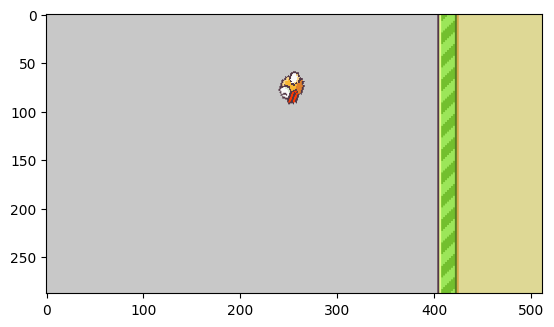

In [311]:
import matplotlib.pyplot as plt
plt.imshow(image)

In [312]:
import cv2
import numpy as np

def pre_processing(image, width , height):
    
    
    _, image = cv2.threshold(image, 1,255,cv2.THRESH_BINARY)
    image = cv2.cvtColor(cv2.resize(image, 
                        (width, height)),cv2.COLOR_BGR2GRAY)
    return image[None,:,:].astype(np.float32)

    


In [313]:
image = pre_processing(image,image_size, image_size)

In [314]:
image.shape


(1, 84, 84)

In [315]:
image = torch.from_numpy(image)
state = torch.cat(tuple(image for _ in range(4) ))[None, :,:,:]

In [316]:
state.shape

torch.Size([1, 4, 84, 84])

In [317]:
for iter in range(n_iter):
    epsilon = final_epsilon + (n_iter - iter)*(init_epsilon- final_epsilon)/n_iter

    policy = gen_epsilon_greedy_policy(estimator, epsilon, n_action)
    action = policy(state)
    next_image, reward, is_done, _, info = env.step(action)
    next_image = pre_processing(next_image, image_size, image_size)
    next_image = torch.from_numpy(next_image)
    #print(state.shape)
    next_state = torch.cat((state[0,1:,:,:],next_image))[None,:,:,:]
    
    memory.append([state,action,next_state, reward, is_done])
    loss = estimator.replay(memory, batch_size, gamma)
    state = next_state
    print("Iteration: {}/{}, Action: {},Loss: {}, Epsilon {}, Reward: {}".format(iter + 1, n_iter, action, loss, epsilon, reward))
    if iter+1 % 10000 == 0: torch.save(estimator.model, "{}/{}".format(saved_path, iter+1))
    if is_done:
        image, _ = env.reset()
        image = pre_processing(image,image_size, image_size)
        image = torch.from_numpy(image)
        
        state = torch.cat(tuple(image for _ in range(4) ))[None, :,:,:]
    


Iteration: 1/2000000, Action: 1,Loss: None, Epsilon 0.1, Reward: 0.1
Iteration: 2/2000000, Action: 1,Loss: None, Epsilon 0.09999995005000001, Reward: 0.1
Iteration: 3/2000000, Action: 1,Loss: None, Epsilon 0.0999999001, Reward: 0.1
Iteration: 4/2000000, Action: 1,Loss: None, Epsilon 0.09999985015, Reward: 0.1
Iteration: 5/2000000, Action: 1,Loss: None, Epsilon 0.0999998002, Reward: 0.1
Iteration: 6/2000000, Action: 1,Loss: None, Epsilon 0.09999975025, Reward: 0.1
Iteration: 7/2000000, Action: 1,Loss: None, Epsilon 0.0999997003, Reward: 0.1
Iteration: 8/2000000, Action: 1,Loss: None, Epsilon 0.09999965035, Reward: 0.1
Iteration: 9/2000000, Action: 1,Loss: None, Epsilon 0.0999996004, Reward: 0.1
Iteration: 10/2000000, Action: 1,Loss: None, Epsilon 0.09999955045000002, Reward: 0.1
Iteration: 11/2000000, Action: 1,Loss: None, Epsilon 0.09999950050000002, Reward: 0.1
Iteration: 12/2000000, Action: 1,Loss: None, Epsilon 0.09999945055000001, Reward: 0.1
Iteration: 13/2000000, Action: 1,Loss: 

Iteration: 37/2000000, Action: 1,Loss: 0.01004518661648035, Epsilon 0.09999820180000002, Reward: 0.1
Iteration: 38/2000000, Action: 1,Loss: 0.010040583088994026, Epsilon 0.09999815185000001, Reward: 0.1
Iteration: 39/2000000, Action: 1,Loss: 0.010013625957071781, Epsilon 0.09999810190000001, Reward: 0.1
Iteration: 40/2000000, Action: 1,Loss: 0.010011633858084679, Epsilon 0.09999805195000001, Reward: 0.1
Iteration: 41/2000000, Action: 1,Loss: 0.010027123615145683, Epsilon 0.09999800200000002, Reward: 0.1
Iteration: 42/2000000, Action: 1,Loss: 0.010022063739597797, Epsilon 0.09999795205, Reward: 0.1
Iteration: 43/2000000, Action: 1,Loss: 0.01001822017133236, Epsilon 0.09999790210000001, Reward: 0.1
Iteration: 44/2000000, Action: 1,Loss: 0.010013229213654995, Epsilon 0.09999785215000001, Reward: 0.1
Iteration: 45/2000000, Action: 0,Loss: 0.010017679072916508, Epsilon 0.09999780220000001, Reward: 0.1
Iteration: 46/2000000, Action: 1,Loss: 0.010004912503063679, Epsilon 0.09999775225, Reward